In [15]:
!pip install sklearn datashader plotly folium pyproj

     |████████████████████████████████| 5.8 MB 573 kB/s            
You should consider upgrading via the '/media/data/miniconda3/envs/ml/bin/python3 -m pip install --upgrade pip' command.


In [46]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Récupération des données sources

In [28]:
df = pd.read_csv('data/DATA 2015-370ACCR ESSAI ML DINUM.csv', delimiter=',')
df.drop(['Coord X' , 'Coord Y'] , axis = 1 ,inplace = True)

df =  pd.concat([df, pd.read_csv('data/DATA 2016-299ACCR ESSAI ML DINUM.csv', delimiter=',').drop(['Coord X' , 'Coord Y'], axis = 1)])
df =  pd.concat([df, pd.read_csv('data/DATA 2017-271ACCR ESSAI ML DINUM.csv', delimiter=',').drop(['Coord X' , 'Coord Y'], axis = 1)])
df =  pd.concat([df, pd.read_csv('data/DATA 2018-316ACCR ESSAI ML DINUM.csv', delimiter=',').drop(['Coord X' , 'Coord Y'], axis = 1)])

# conversion lamber to lat long

df =  pd.concat([df, pd.read_csv('data/DATA 2019-363ACCR ESSAI ML DINUM.csv', delimiter=',').drop(['Latitude' , 'Longitude'], axis = 1)])
df =  pd.concat([df, pd.read_csv('data/DATA 2020-333ACCR ESSAI ML DINUM.csv', delimiter=',').drop(['Latitude' , 'Longitude'], axis = 1)])

#df['Coord X'] = df['Coord X'].applymap(lambda x: x.strip().replace(' ', '') if isinstance(x, str) else x)
# df['Coord X'] = df['Coord X'].str.replace(' ', '')
# df['Coord X'] = pd.to_numeric(df["Coord X"])

print(df.head())
df.describe()

          Date - Heure      Code commune           Gravite Observations  \
0  28/03/2015 09:00:00   98816 - Moindou  Grave Non Mortel          NaN   
1  02/05/2015 10:10:00   98816 - Moindou  Grave Non Mortel          NaN   
2  02/07/2015 06:45:00    98806 - Farino  Grave Non Mortel          NaN   
3  06/07/2015 18:30:00    98813 - La Foa  Grave Non Mortel          NaN   
4  04/10/2015 21:45:00  98828 - Sarramea  Grave Non Mortel          NaN   

  Unnamed: 5  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN  


,Date - Heure,Code commune,Gravite,Observations,Unnamed: 5
count,1951,1951,1951,9,35
unique,1947,34,3,1,2
top,14/05/2017 11:00:00,98818 - Noumea,Leger,Localisation estimee,Localisation estimee
freq,2,1126,881,9,34


<AxesSubplot:xlabel='day_of_year'>

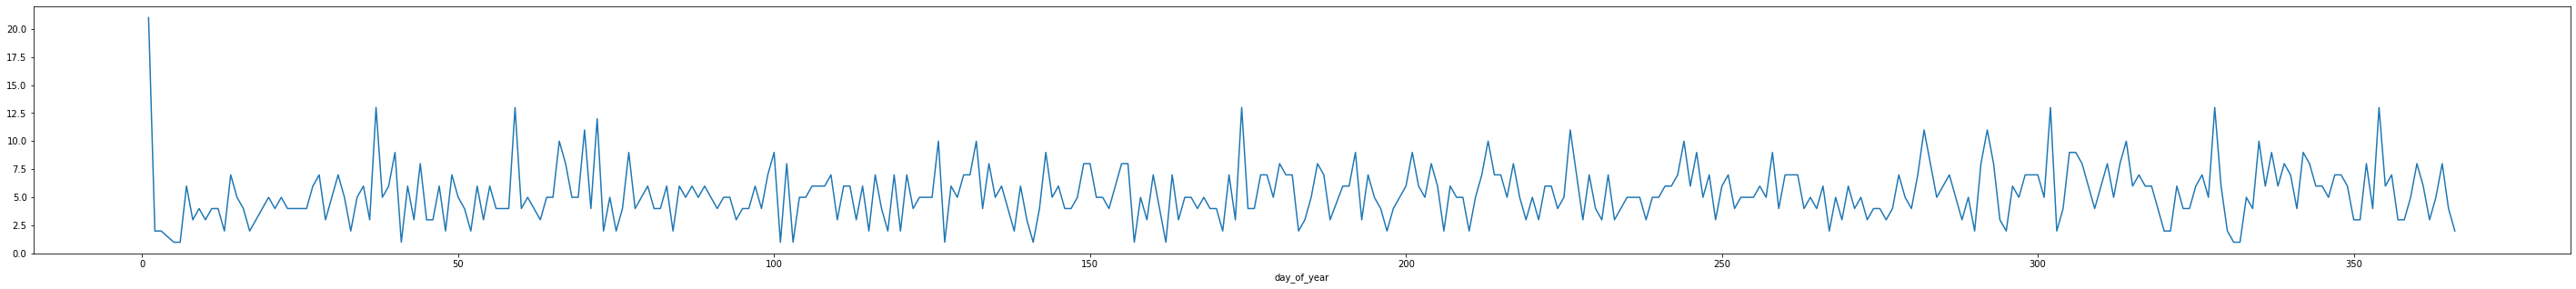

In [56]:
df1 = df
df1['date_heure'] = pd.to_datetime(df1['Date - Heure'], format='%d/%m/%Y %H:%M:%S')
df1['day_of_year'] = df1['date_heure'].dt.day_of_year
df1['date'] = df1['date_heure'].dt.date
df1['month'] = df1['date_heure'].dt.month
df1['hour'] = df1['date_heure'].dt.hour
df1['day_of_week'] = df1['date_heure'].dt.day_of_week
df1.groupby(['day_of_year']).size().plot(figsize=(50,5))

<AxesSubplot:xlabel='month'>

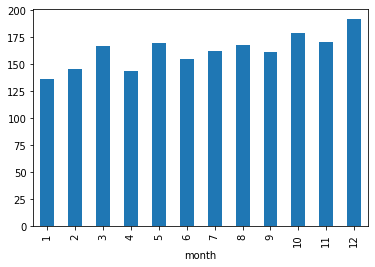

In [51]:
df1.groupby(['month']).size().plot(kind='bar')

<AxesSubplot:xlabel='day_of_week'>

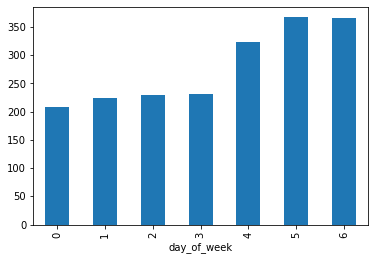

In [52]:
df1.groupby(['day_of_week']).size().plot(kind='bar')

<AxesSubplot:xlabel='hour'>

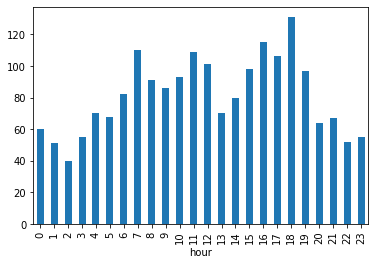

In [55]:
df1.groupby(['hour']).size().plot(kind='bar')


In [101]:
df2 = df1.groupby(['date']).size().reset_index(name='count')
print(df2.head())
print(df2.shape)
idx = pd.date_range(min(df2.date), max(df2.date))
df2 = df2.set_index(['date'], drop=True)
df2.index = pd.DatetimeIndex(df2.index)
df2 = df2.reindex(idx, fill_value=0)
print(df2.head())
print(df2.shape)
df2.describe()

         date  count
0  2015-01-01      4
1  2015-01-02      1
2  2015-01-09      2
3  2015-01-10      1
4  2015-01-11      1
(1277, 2)
            count
2015-01-01      4
2015-01-02      1
2015-01-03      0
2015-01-04      0
2015-01-05      0
(2192, 1)


,count
count,2192.000000
mean,0.890055
std,0.978664
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,6.000000


<AxesSubplot:>

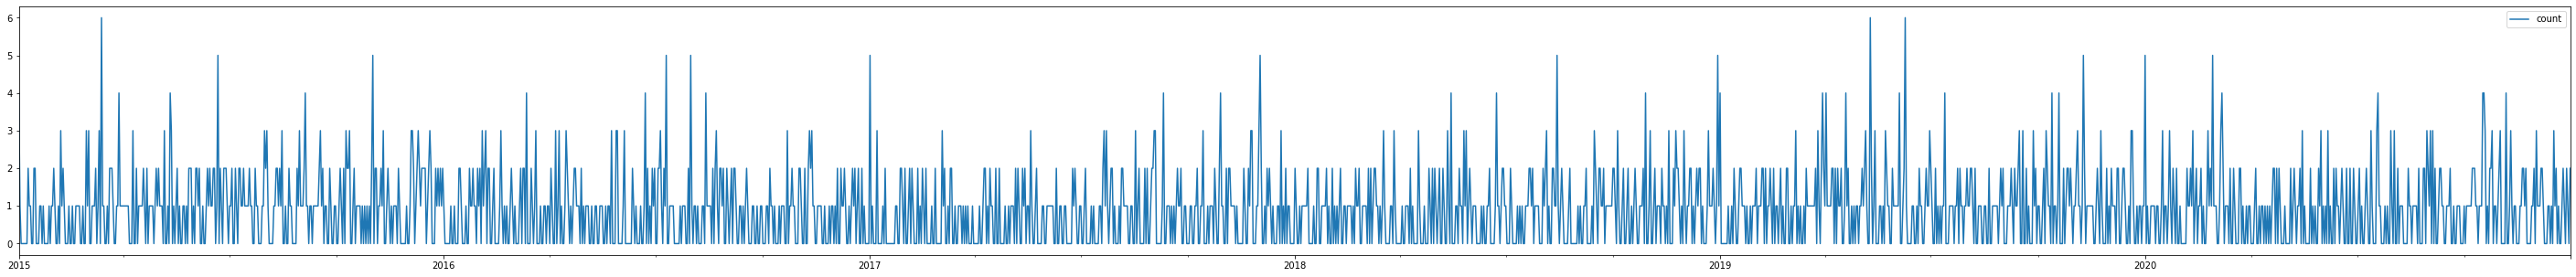

In [102]:
df2.plot(figsize=(50,5))

In [112]:
shifted_df = df2.shift()
concat_df = [df2, shifted_df]
data = pd.concat(concat_df, axis=1)
data.fillna(0, inplace=True)
data

,count,count
2015-01-01,4,0.0
2015-01-02,1,4.0
2015-01-03,0,1.0
2015-01-04,0,0.0
2015-01-05,0,0.0
...,...,...
2020-12-27,0,1.0
2020-12-28,2,0.0
2020-12-29,1,2.0
2020-12-30,0,1.0


In [113]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

data = np.array(data)
train, test = data[:-50], data[-50:]

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.fit_transform(test)

In [114]:
# train data
y_train = train_scaled[:,-1]
X_train = train_scaled[:,0:-1]
X_train = X_train.reshape(len(X_train),1,1)
# test data
y_test = test_scaled[:,-1]
X_test = test_scaled[:,0:-1]

In [124]:
from keras.models import Sequential
from keras.layers import * 
from keras.optimizers import *
import math
from sklearn.metrics import mean_squared_error

model = Sequential()
model.add(GRU(75, input_shape=(1,1)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, batch_size=2, shuffle=False)


Epoch 1/100
1071/1071 [==============================] - 8s 5ms/step - loss: 0.0271 - accuracy: 0.4188
Epoch 2/100
1071/1071 [==============================] - 6s 6ms/step - loss: 0.0270 - accuracy: 0.4188
Epoch 3/100
1071/1071 [==============================] - 6s 6ms/step - loss: 0.0269 - accuracy: 0.4188
Epoch 4/100
1071/1071 [==============================] - 6s 6ms/step - loss: 0.0269 - accuracy: 0.4188
Epoch 5/100
1071/1071 [==============================] - 6s 6ms/step - loss: 0.0268 - accuracy: 0.4188
Epoch 6/100
1071/1071 [==============================] - 5s 5ms/step - loss: 0.0268 - accuracy: 0.4188
Epoch 7/100
1071/1071 [==============================] - 5s 5ms/step - loss: 0.0268 - accuracy: 0.4188
Epoch 8/100
1071/1071 [==============================] - 5s 4ms/step - loss: 0.0268 - accuracy: 0.4188
Epoch 9/100
1071/1071 [==============================] - 5s 4ms/step - loss: 0.0268 - accuracy: 0.4188
Epoch 10/100
1071/1071 [==============================] - 5s 5ms/step - l

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [131]:
# make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

ValueError: non-broadcastable output operand with shape (2142,1) doesn't match the broadcast shape (2142,2)

In [130]:

# shift train predictions for plotting
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

NameError: name 'trainPredict' is not defined

In [141]:
# LSTM for international airline passengers problem with regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = df2
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))



N_INPUTS = 1 #(1, look_back)
TIMESERIES_COL = "count"
# create and fit the LSTM network
# model = Sequential()
# model.add(LSTM(12, input_shape=N_INPUTS))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')

# model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.InputLayer(input_shape = [N_INPUTS], name = TIMESERIES_COL))
# model.add(tf.keras.layers.Reshape(target_shape = [N_INPUTS, 1]))
# model.add(tf.keras.layers.LSTM(units = N_INPUTS * 2, return_sequences = True))
# model.add(tf.keras.layers.LSTM(units = N_INPUTS // 2))
# model.add(tf.keras.layers.Dense(units = (N_INPUTS // 2) // 2, activation = tf.nn.relu))
# model.add(tf.keras.layers.Dense(units = 1, activation = None))
# model.compile(optimizer = "adam", loss = "rmse",metrics = ["rmse"])

# dense_dropout = 0.4
# activation_fct = "elu"
# dense_window = 400
# dense=200
# dense_final=100

# model = tf.keras.models.Sequential([
#     tf.keras.layers.Dense(dense_window, input_shape=[N_INPUTS], activation=activation_fct), 
#     tf.keras.layers.Dropout(dense_dropout),
#     tf.keras.layers.Dense(dense_window, input_shape=[N_INPUTS], activation=activation_fct), 
#     tf.keras.layers.Dropout(dense_dropout),
#     tf.keras.layers.Dense(dense_window, input_shape=[N_INPUTS], activation=activation_fct),
#     tf.keras.layers.Dropout(dense_dropout),
#     tf.keras.layers.Dense(dense_window, input_shape=[N_INPUTS], activation=activation_fct),
#     tf.keras.layers.Dropout(dense_dropout),
#     tf.keras.layers.Dense(dense_window, input_shape=[N_INPUTS], activation=activation_fct), 
#     tf.keras.layers.Dropout(dense_dropout),
#     tf.keras.layers.Dense(dense_window, input_shape=[N_INPUTS], activation=activation_fct), 
#     tf.keras.layers.Dropout(dense_dropout),
#     tf.keras.layers.Dense(dense_window, input_shape=[N_INPUTS], activation=activation_fct),
#     tf.keras.layers.Dropout(dense_dropout),
#     tf.keras.layers.Dense(dense_window, input_shape=[N_INPUTS], activation=activation_fct),
#     tf.keras.layers.Dropout(dense_dropout),
#     tf.keras.layers.Dense(dense, activation=activation_fct),
#     tf.keras.layers.Dense(dense, activation=activation_fct),
#     tf.keras.layers.Dense(dense, activation=activation_fct),
#     tf.keras.layers.Dense(dense, activation=activation_fct),
#     tf.keras.layers.Dense(dense, activation=activation_fct),
#     tf.keras.layers.Dense(dense, activation=activation_fct),
#     tf.keras.layers.Dense(dense_final, activation=activation_fct),
#     tf.keras.layers.Dense(dense_final, activation=activation_fct),
#     tf.keras.layers.Dense(1)
# ])

model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5)) 

history = model.fit(trainX, trainY, epochs=200, batch_size=10, verbose=2)


Epoch 1/200
147/147 - 6s - loss: 0.0354 - 6s/epoch - 38ms/step
Epoch 2/200
147/147 - 2s - loss: 0.0305 - 2s/epoch - 17ms/step
Epoch 3/200
147/147 - 3s - loss: 0.0279 - 3s/epoch - 20ms/step
Epoch 4/200
147/147 - 2s - loss: 0.0275 - 2s/epoch - 16ms/step
Epoch 5/200
147/147 - 2s - loss: 0.0273 - 2s/epoch - 17ms/step
Epoch 6/200
147/147 - 2s - loss: 0.0269 - 2s/epoch - 16ms/step
Epoch 7/200
147/147 - 3s - loss: 0.0266 - 3s/epoch - 21ms/step
Epoch 8/200
147/147 - 3s - loss: 0.0263 - 3s/epoch - 21ms/step
Epoch 9/200
147/147 - 3s - loss: 0.0265 - 3s/epoch - 19ms/step
Epoch 10/200
147/147 - 3s - loss: 0.0266 - 3s/epoch - 20ms/step
Epoch 11/200
147/147 - 3s - loss: 0.0263 - 3s/epoch - 19ms/step
Epoch 12/200
147/147 - 3s - loss: 0.0263 - 3s/epoch - 20ms/step
Epoch 13/200
147/147 - 3s - loss: 0.0262 - 3s/epoch - 18ms/step
Epoch 14/200
147/147 - 3s - loss: 0.0261 - 3s/epoch - 21ms/step
Epoch 15/200
147/147 - 3s - loss: 0.0261 - 3s/epoch - 18ms/step
Epoch 16/200
147/147 - 3s - loss: 0.0261 - 3s/epo

KeyError: 'val_loss'

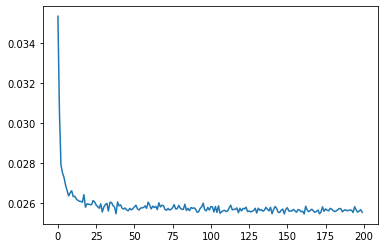

In [142]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Train Score: 0.96 RMSE
Test Score: 1.01 RMSE


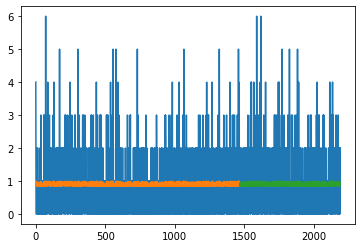

In [143]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()